                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  
Training model for toxic
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     28859
           1       0.53      0.

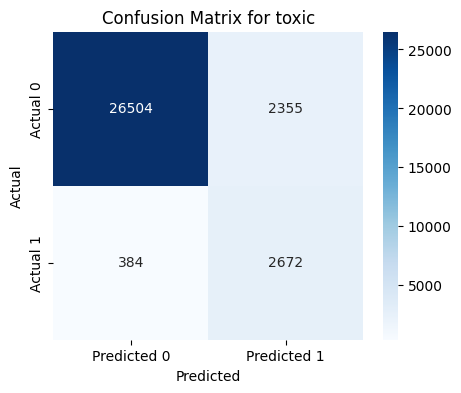

Training model for severe_toxic
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     31594
           1       0.18      0.88      0.30       321

    accuracy                           0.96     31915
   macro avg       0.59      0.92      0.64     31915
weighted avg       0.99      0.96      0.97     31915

F1 Score: 0.3039
Negative Score: 0.9605
Positive Score: 0.8754
Mean Score: 0.9180


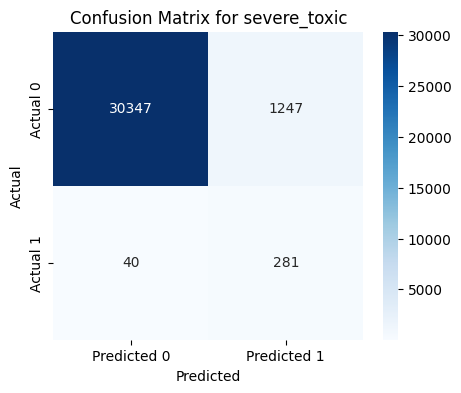

Training model for obscene
              precision    recall  f1-score   support

           0       0.99      0.96      0.97     30200
           1       0.54      0.89      0.67      1715

    accuracy                           0.95     31915
   macro avg       0.77      0.92      0.82     31915
weighted avg       0.97      0.95      0.96     31915

F1 Score: 0.6700
Negative Score: 0.9566
Positive Score: 0.8892
Mean Score: 0.9229


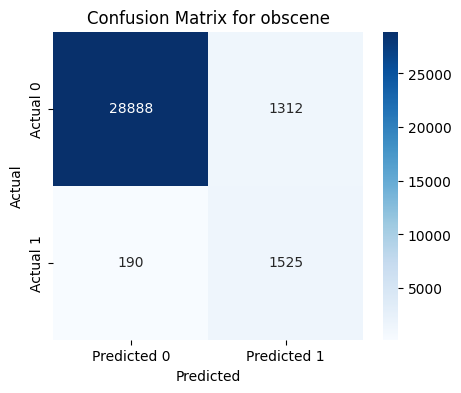

Training model for threat
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     31841
           1       0.05      0.88      0.09        74

    accuracy                           0.96     31915
   macro avg       0.52      0.92      0.53     31915
weighted avg       1.00      0.96      0.98     31915

F1 Score: 0.0874
Negative Score: 0.9577
Positive Score: 0.8784
Mean Score: 0.9180


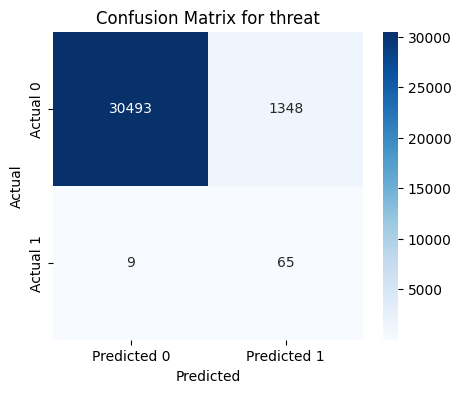

Training model for insult
              precision    recall  f1-score   support

           0       0.99      0.93      0.96     30301
           1       0.41      0.89      0.56      1614

    accuracy                           0.93     31915
   macro avg       0.70      0.91      0.76     31915
weighted avg       0.96      0.93      0.94     31915

F1 Score: 0.5610
Negative Score: 0.9316
Positive Score: 0.8903
Mean Score: 0.9110


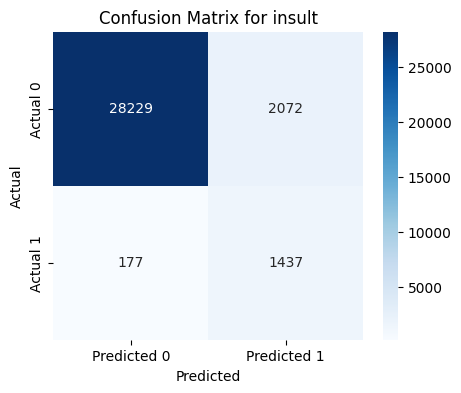

Training model for identity_hate
              precision    recall  f1-score   support

           0       1.00      0.93      0.97     31621
           1       0.11      0.86      0.19       294

    accuracy                           0.93     31915
   macro avg       0.55      0.90      0.58     31915
weighted avg       0.99      0.93      0.96     31915

F1 Score: 0.1911
Negative Score: 0.9338
Positive Score: 0.8571
Mean Score: 0.8955


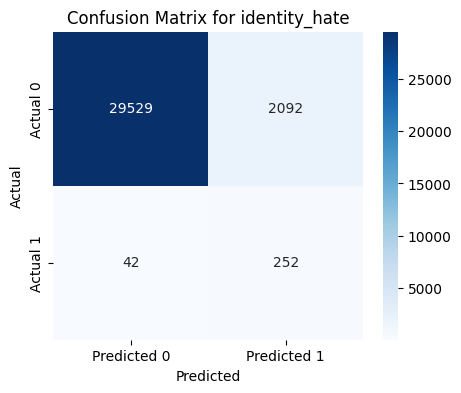

In [ ]:
# Importation des bibliothèques nécessaires
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler

data = pd.read_csv('./data/train.csv')

print(data.head())

X = data['comment_text']
y = data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

# On divise les données en un ensemble d'entraînement et un ensemble de test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# On vectorise les données à l'aide de la méthode TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# On entraîne un modèle de régression logistique pour chaque label.
for label in y.columns:
    # On sous-échantillonne les données pour équilibrer les classes.
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X_train_tfidf, y_train[label])

    # Regression logistique (pas l'objectif du projet mais on obtient des résultats corrects).
    model = LogisticRegression(max_iter=300)
    model.fit(X_resampled, y_resampled)

    y_pred = model.predict(X_test_tfidf)

    report = classification_report(y_test[label], y_pred, labels=[0, 1])
    print(report)

    # Matrice de confusion
    cm = confusion_matrix(y_test[label], y_pred)

    # F1 Score en plus.
    f1 = f1_score(y_test[label], y_pred)
    print(f"F1 Score: {f1:.4f}")

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix for {label}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


In [5]:
# Préparation de la soumission pour Kaggle
# Chargement des données de test Kaggle
test_data = pd.read_csv('./data/test.csv')
test_comments = test_data['comment_text']

# Vectorisation des commentaires de test
X_test_kaggle_tfidf = vectorizer.transform(test_comments)

# Prédiction pour chaque catégorie
submission = pd.DataFrame()
submission['id'] = test_data['id']

for label in y.columns:
    # Équilibrage des données
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X_train_tfidf, y_train[label])

    # Entraînement du modèle
    model = LogisticRegression(max_iter=300)
    model.fit(X_resampled, y_resampled)

    # Prédiction
    submission[label] = model.predict_proba(X_test_kaggle_tfidf)[:, 1]


# Sauvegarde de la soumission
submission.to_csv('./submissions/LogisticRegressionBalanced-submission.csv', index=False)